# Tracking Filter

source:

`Kalman and Bayesian Filters in Python` author: Roger R Labbe Jr

adapted from chapter 2 of `Kalman_and_Bayesian_Filters_in_Python.pdf`

**Motivation**

Working through the first chapters to learn about `Kalman-Filtering`.

Experience so far:

1) Reading chapter 2 and understanding its content is fairly easy.
  
2) Very light on math. I am curious how this will change in subsequent chapters when it comes to how a `Kalman-Filter` works. 


---

## Problem Statement

At time $t_0$ a vehicle starts with constant velocity $v_c$ at location $s_0$.

At time instants $\{t_0, t_1, \ldots, t_n\}$ the vehicles position is at $\{s_0, s_1, \ldots, s_n \}$. From the physical laws of motion we have:

$$
s(t_n) = s_0 + v_c \cdot t_n
$$

At time instants $\{t_0, t_1, \ldots, t_n\}$ the vehicle's position is measured. Measured position at time $t_m$ is $z(t_m)$. Ideally we would expect
$z(t_m) = s(t_m)$ but in practice some uncertainty must be accounted for. Thus the measured position deviates generally from the true position by some position error $w(t_m)$.

$$
z(t_m) = s(t_m) + w(t_m)
$$

Position error $w(t_m)$ shall follow some statistical distribution with zero mean $\mu_w$ and standard deviation $\sigma_w$.

**Initial conditions**

The true velocity $v_c$ is not known beforehand. What is known however is a *guess* of the velocity. This guess is denoted $v_g$.

The true (initial) position $s_0$ is not known either. We only have an estimate $s_i$ of this position.

What is known *exactly* are time instants $t_m$.

We shall assume that we do know time instants $t_m$ exactly but we only have a more or less accurate *guess* $v_g$ of velocity $v_c$.

With these definitions in place we generate an artificial data set and display it graphically.

---

## An artificial data set

**time instants**

Time instants $t_n = n \cdot \Delta t$ with $n := [0, ..., 100]$  and $\Delta t = 1 \ [s]$.

**True velocity**

$v_c = 2 \ [m/s]$

**True initial position**

$s_0 = 10 \ m$

**Position error $w(t_m)$**

$w(t_m)$ shall be uniformly distributed in the range $-d \ [m] \le w(t_m) \le d \ [m]$. $d \ge 0$ denotes the *maximum absolute position error*.

In the artificial data set we choose $d = 5 \ [m]$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
# number of data points / measurements
N = 100
# time increment [s]
dt = 1
# true velocity [m/s]
vc = 2
# true initial position
s0 = 10
# absolute position error [m]
d = 5

# time instants
tvec = np.arange(N, dtype=float) * dt
# true positions 
svec = vc * tvec + s0
# measured positions
mvec = svec + stats.uniform.rvs(loc=-d, scale=2*d, size=N)


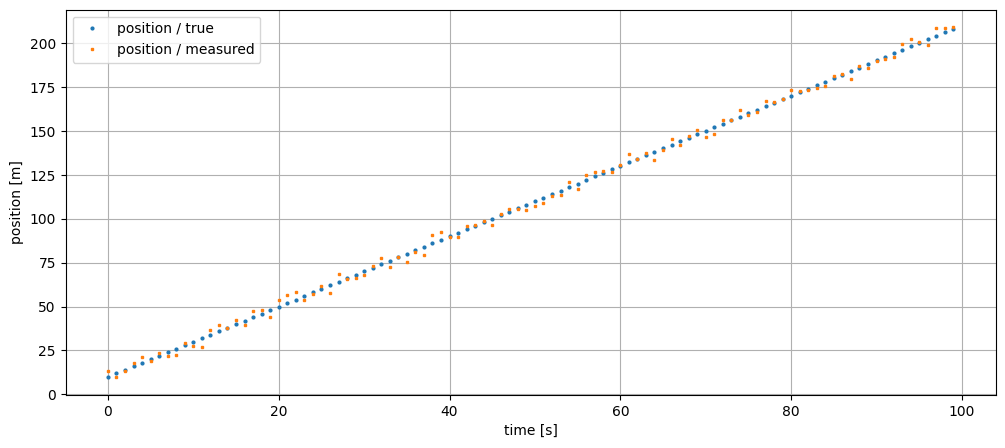

In [3]:
fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12,5))

ax1.plot(tvec, svec, linestyle='', marker='o', markersize=2, label='position / true')
ax1.plot(tvec, mvec, linestyle='', marker='s', markersize=2, label='position / measured')
ax1.set_xlabel('time [s]')
ax1.set_ylabel('position [m]')
ax1.set_title('')
ax1.legend()
ax1.grid(True)

## Preliminary Tracking Example

Given the artificial data set we will construct a procedure to estimate the true position $s(t_n)$ at every time instant $t_n$. 

**time step $t_0$**

At time instant $t_0$ we *guess* that the initial position is $s_i$ and the velocity is $v_g$.
As there is an additional measurement value $z(t_0$ available we must decide how to combine the *guessed* initial position $s_i$ and the measured value into an estimated position $s_e(t_0)$. We will use:

$$
s_e(t_0) = s_i + k_f \cdot \underbrace{(z(t_0) - s_i)}_{r(t_0)}
$$

$r(t_0$ denotes the residual at time $t_0$ and $k_f$ is a weighting factor in the range $[0, \ldots, 1]$. A larger value of $k_f$ means we are more confident on the measured value.

**time steps $ \{t_1,\ \ldots,\ t_n\}$**


We then *predict* the position $s_p(t_m)$ to be at:

$$
s_p(t_m) = s_e(t_{m-1} + v_g \cdot (t_m - t_{m-1})
$$

This is equivalent to starting from the previously estimated position $s_e(t_{m-1}$, applying our guessed velocity $v_g$ and then time step $(t_m - t_{m-1})$.

At time $t_m$ we get the measured position $z(t_m)$. It will in general deviate from the predicted position $s_p(t_m)$. The residual is denoted $r(t_m)$:

$$
r(t_m) = z(t_m) - s_p(t_m)
$$

Using the predicted position $s_p(t_m)$ and the deviation $r(t_m)$ we construct an estimate of the position at $t_m$.

$$
s_e(t_m) = s_p(t_m) + k_f \cdot r(t_m)
$$

Note that factor $k_f$ remains unchanged for every time instant !


Let's program this and compute the estimated position for every time instant. Moreover the deviation $e(t_m)$ between estimated position $s_e(t_m)$ and true position $s(t_m)$ shall be computed and visualized.

$$
e(t_m) = s(t_m) - s_e(t_m)
$$

---

In [4]:
# estimated initial position
se_init = 50
# estimated velocity
vg = 1.0
# weighting factor
kf = 0.4

# array of estimated positions
se_vec = []

for k in range(N):
    measurement = mvec[k]
    if k == 0:
        residual = measurement - se_init
        estimate = se_init + kf * residual
        se_vec.append(estimate)
    else:
        time_step = tvec[k]-tvec[k-1]
        predicted = se_vec[k-1] + vg * time_step
        residual = measurement - predicted
        estimate = predicted + kf * residual
        se_vec.append(estimate)

error = svec - se_vec

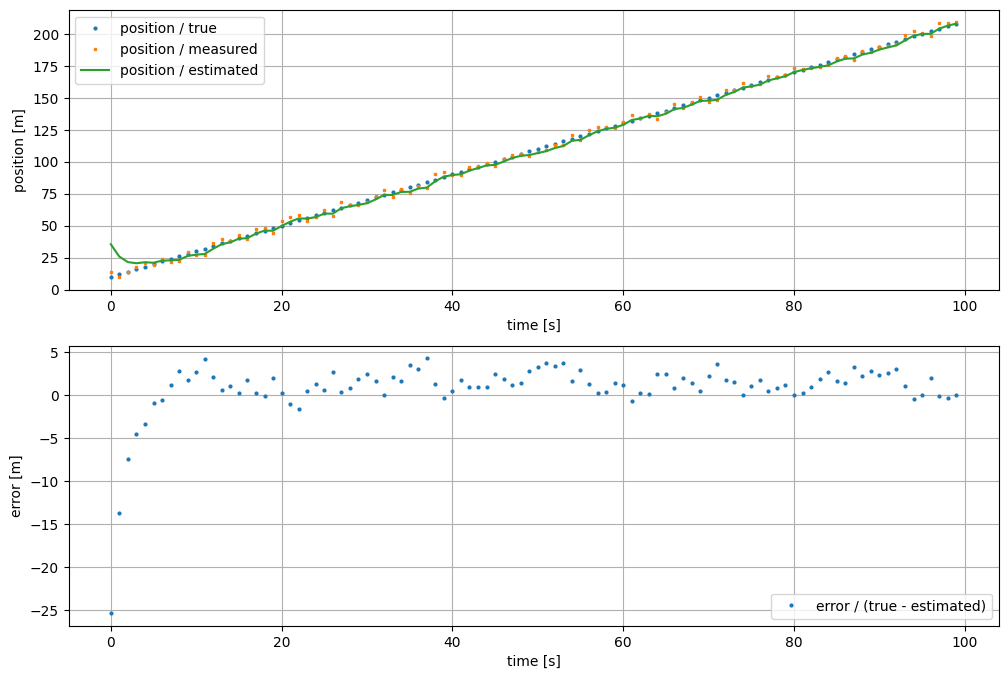

In [5]:
fig2, ax2 = plt.subplots(nrows=2, ncols=1, figsize=(12,8))

ax2[0].plot(tvec, svec, linestyle='', marker='o', markersize=2, label='position / true')
ax2[0].plot(tvec, mvec, linestyle='', marker='s', markersize=2, label='position / measured')
ax2[0].plot(tvec, se_vec, label='position / estimated')
ax2[0].set_xlabel('time [s]')
ax2[0].set_ylabel('position [m]')
ax2[0].set_title('')
ax2[0].legend()
ax2[0].grid(True)

ax2[1].plot(tvec, error, linestyle='', marker='o', markersize=2, label='error / (true - estimated)')
ax2[1].set_xlabel('time [s]')
ax2[1].set_ylabel('error [m]')
ax2[1].set_title('')
ax2[1].legend()
ax2[1].grid(True)

**Summary**

The artificial data set is estimated fairly well, given that:

1) we start with an initial position which is far off the starting position of the data set

2) we use a guess for the velocity which deviates considerably from the true value

3) we estimate the position without taking into account that should adapt the initial velocity with every new measurement
estimation procedure does not currently predict the velocity (which is kept constant) in all prediction steps. 

In the following some adjustments are made to remedy these shortcomings.

---

## Improved Tracking Example

Given the artificial data set we will construct a procedure to estimate the true position $s(t_n)$ at every time instant $t_n$. Additionally we will update the velocity with every new time step.

**time step $t_0$**

At time instant $t_0$ we *guess* that the initial position is $s_i$ and the velocity is $v_g$.
As there is an additional measurement value $z(t_0$ available we must decide how to combine the *guessed* initial position $s_i$ and the measured value into an estimated position $s_e(t_0)$. We will use:

$$
s_e(t_0) = s_i + k_f \cdot \underbrace{(z(t_0) - s_i)}_{r(t_0)}
$$

$r(t_0)$ denotes the residual at time $t_0$ and $k_f$ is a weighting factor in the range $[0, \ldots, 1]$. A larger value of $k_f$ means we are more confident on the measured value.

For the estimated velocity $v_e(t_0)$ at time $t_0$ the only information we have is $v_g$. Hence we set:

$$
v_e(t_0) = v_g
$$

**time steps $ \{t_1,\ \ldots,\ t_n\}$**


We then *predict* the position $s_p(t_m)$ to be at:

$$
s_p(t_m) = s_e(t_{m-1} + v_e(t_{m-1}) \cdot (t_m - t_{m-1})
$$

This is equivalent to starting from the previously estimated position $s_e(t_{m-1}$, applying our updated velocity $v_e(t_{m-1})$ and then time step $(t_m - t_{m-1})$.

At time $t_m$ we get the measured position $z(t_m)$. It will in general deviate from the predicted position $s_p(t_m)$. The residual is denoted $r(t_m)$:

$$
r(t_m) = z(t_m) - s_p(t_m)
$$

Using the predicted position $s_p(t_m)$ and the deviation $r(t_m)$ we construct an estimate of the position at $t_m$.

$$
s_e(t_m) = s_p(t_m) + k_f \cdot r(t_m)
$$

Note that factor $k_f$ remains unchanged for every time instant !

For the estimated velocity $v_e(t_m)$ we have:

$$
v_e(t_m) = v_e(t_{m-1}) + k_v \cdot \frac{r(t_m)}{t_m - t_{m-1}}
$$

$k_v$ is a constant weighting factor for updating the velocity. The range of $k_v$ is $[0,\ \ldots,\ 1]$.

Let's program this and compute the estimated position for every time instant. Moreover the deviation $e(t_m)$ between estimated position $s_e(t_m)$ and true position $s(t_m)$ shall be computed and visualized.

$$
e(t_m) = s(t_m) - s_e(t_m)
$$

---

In [6]:
# estimated initial position
position_init = -10
# estimated initial velocity
velocity_init = 0.0

# weighting factor position
kf = 0.2
# weighting factor velocity
kv = 0.05

pos_estimates = []
v_estimates = []

for k in range(N):
    measurement = mvec[k]
    if k == 0:
        residual = measurement - position_init
        estimate_p = position_init + kf * residual
        pos_estimates.append(estimate_p)
        v_estimates.append(velocity_init)
    else:
        time_step = tvec[k]-tvec[k-1]
        predicted_p = pos_estimates[k-1] + v_estimates[k-1] * time_step
        residual = measurement - predicted_p
        estimate_p = predicted_p + kf * residual
        pos_estimates.append(estimate_p)
        estimate_v = v_estimates[k-1] + kv * residual / time_step
        v_estimates.append(estimate_v)

error_pos = svec - np.array(pos_estimates)
error_v = vc - np.array(v_estimates)

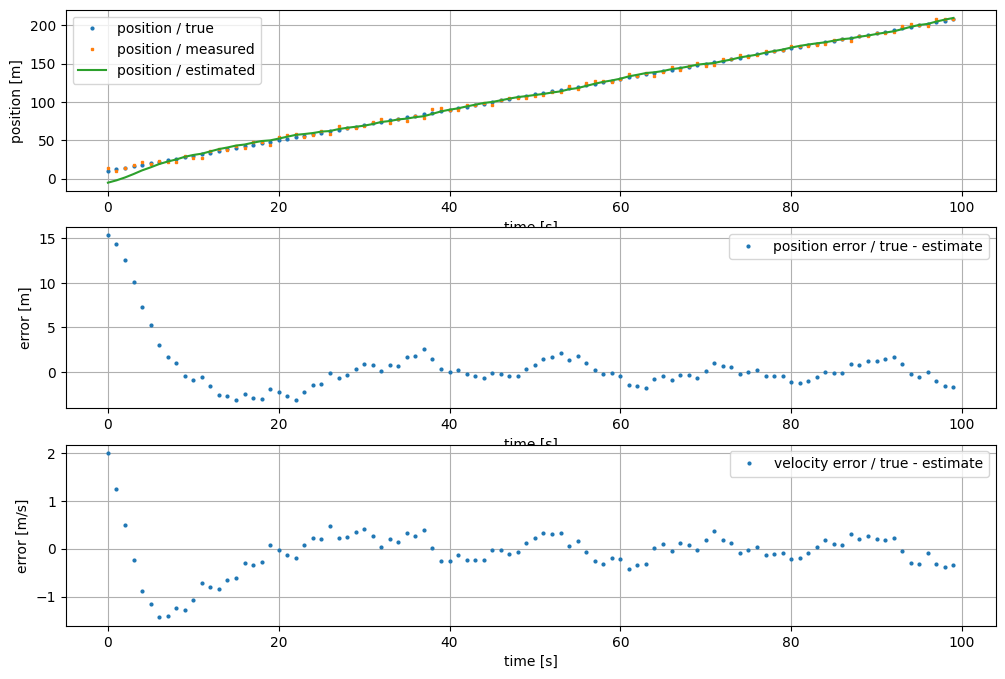

In [7]:
fig3, ax3 = plt.subplots(nrows=3, ncols=1, figsize=(12,8))

ax3[0].plot(tvec, svec, linestyle='', marker='o', markersize=2, label='position / true')
ax3[0].plot(tvec, mvec, linestyle='', marker='s', markersize=2, label='position / measured')
ax3[0].plot(tvec, pos_estimates, label='position / estimated')
ax3[0].set_xlabel('time [s]')
ax3[0].set_ylabel('position [m]')
ax3[0].set_title('')
ax3[0].legend()
ax3[0].grid(True)

ax3[1].plot(tvec, error_pos, linestyle='', marker='o', markersize=2, label='position error / true - estimate')
ax3[1].set_xlabel('time [s]')
ax3[1].set_ylabel('error [m]')
ax3[1].set_title('')
ax3[1].legend()
ax3[1].grid(True)

ax3[2].plot(tvec, error_v, linestyle='', marker='o', markersize=2, label='velocity error / true - estimate')
ax3[2].set_xlabel('time [s]')
ax3[2].set_ylabel('error [m/s]')
ax3[2].set_title('')
ax3[2].legend()
ax3[2].grid(True)

## A generic g-h filter

**data**

Data (measurements) are provided at discrete time steps $z(t_m); \ m = 0,\ \ldots, M-1$. Time steps shall be equidistant. Thus
$\Delta t = t_m - t_{m-1} = const$ . For a shorter notation data are denoted $z_m = z(t_m)$.

**estimated data**

From the set of data values the set of estimated data is generated. Data estimates are denoted $x_m; \ m = 0,\ \ldots, M-1$. The estimates of *rate changes* are denoted $v_m; \ m = 0,\ \ldots, M-1$.

**initial values**

$x_0$ is the initial estimate. $v_0$ is the initial estimate of *rate change*. A good choice for $x_0$ is the data value at time instant $t_0$. Thus $x_0 = z_0$.

**predicted data**

For each time instant $t_1, t_2,\ \ldots,\ t_{M-1}$ a predictions is made for the data value and the rate change.

$x_{m | m-1} = x_{m-1} + v_{m-1} \cdot \Delta t$

$v_{m | m-1} = v_{m-1}$

From the predicted data new estimates are computed.

$x_m = x_{m | m-1} + k_f \cdot (z_m - x_{m | m-1})$

$v_m = v_{m | m-1} + k_v \cdot \frac{z_m - x_{m | m-1}}{\Delta t}$^


In the literature weighting factors $k_f$ and $k_v$ are often referred to as weighting factors $g$ and $h$. Hence the name `g-h filter`.

In [15]:
def g_h_filter (data, x0, dx0, g, h, dt):
    """
    data : a M point data set as list or numpy array
    x0   : initial position / data point
    dx0  : initial velocity / change rate
    g    : weighting factor for position / data  updates
    h    : weighting factor for velocity / change rate updates
    dt   : fixed step size (time step)
    """
    # intialise position and change rate
    x = x0
    dx = dx0
    x_estimates = []
    for z in data:
        # prediction 
        x_predict = x + dx * dt
        dx_predict = dx
        # update 
        residual = z - x_predict
        x = x_predict + g * residual
        dx = dx_predict + h * (residual/dt)
        x_estimates.append(x)

    return np.array(x_estimates)


# the function is saved to file to do further experiments with the g-h filter

In [21]:
# test this function and use different initial values for position and rate change

x_init_1 = -50
dx_init_1 = 0.0
x_init_2 = -0
dx_init_2 = 3.0
x_init_3 = 30
dx_init_3 = 1.0

estimates_1 = g_h_filter (mvec, x_init_1, dx_init_1, 0.2, 0.05, 1.0)
estimates_2 = g_h_filter (mvec, x_init_2, dx_init_2, 0.2, 0.05, 1.0)
estimates_3 = g_h_filter (mvec, x_init_3, dx_init_3, 0.2, 0.05, 1.0)

abs_err_1_2 = np.abs(estimates_1 - estimates_2)
abs_err_1_3 = np.abs(estimates_1 - estimates_3)
abs_err_2_3 = np.abs(estimates_2 - estimates_3)

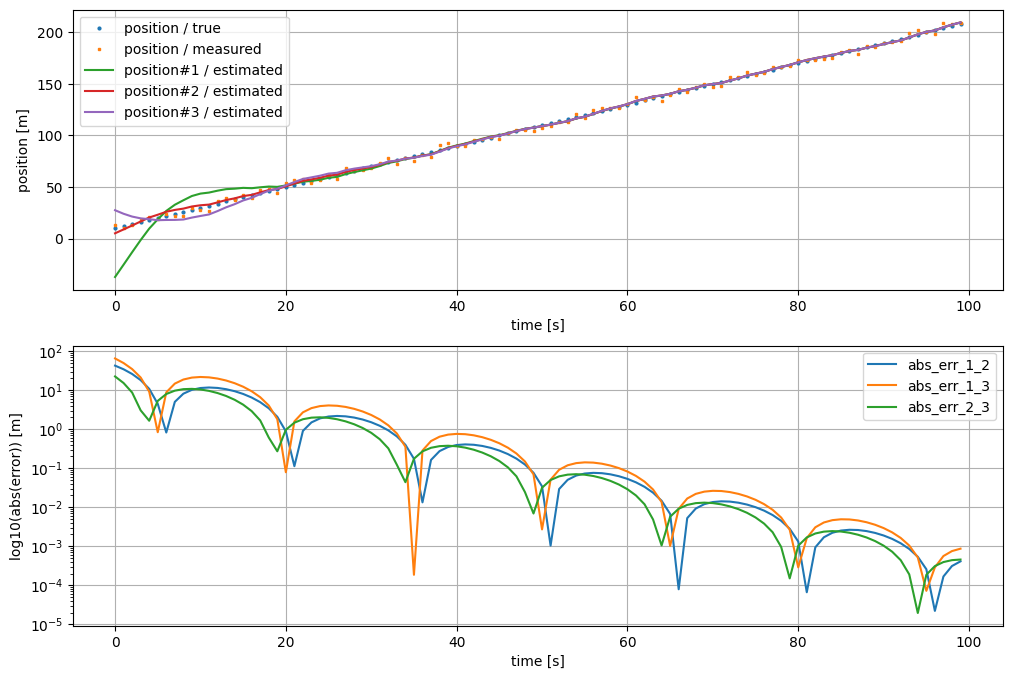

In [23]:
# visualise it
fig4, ax4 = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
ax4[0].plot(tvec, svec, linestyle='', marker='o', markersize=2, label='position / true')
ax4[0].plot(tvec, mvec, linestyle='', marker='s', markersize=2, label='position / measured')
ax4[0].plot(tvec, estimates_1, label='position#1 / estimated')
ax4[0].plot(tvec, estimates_2, label='position#2 / estimated')
ax4[0].plot(tvec, estimates_3, label='position#3 / estimated')
ax4[0].set_xlabel('time [s]')
ax4[0].set_ylabel('position [m]')
ax4[0].set_title('')
ax4[0].legend()
ax4[0].grid(True)

ax4[1].semilogy(tvec, abs_err_1_2, label='abs_err_1_2')
ax4[1].semilogy(tvec, abs_err_1_3, label='abs_err_1_3')
ax4[1].semilogy(tvec, abs_err_2_3, label='abs_err_2_3')
ax4[1].set_xlabel('time [s]')
ax4[1].set_ylabel('log10(abs(error)) [m]')
ax4[1].set_title('')
ax4[1].legend()
ax4[1].grid(True)

**Conclusion**

Although 3 very different starting values have been used to initialise the `g-h-filter` the estimated positions seem to converge after about 40 time steps ; see 2`nd row if plot. 

In another `Jupyter notebook` a few other data sets will be used and the responses of the `g-h filter` will be computed and displayed.